# Building a neural network

### Neural networks in code

Building a neural network from scratch in code is no mean feat. Some people make a habit out of it, sometimes going so far as to [live code a neural net library in one hour](https://www.youtube.com/watch?v=o64FV-ez6Gw).

Fortunately, Python [is batteries-included](https://xkcd.com/353/) and has a wonderful community of ML practitioners. There are a number of wonderful, fully-developed and well-supported libraries out there for building and training neural networks.

### Keras 

[Keras](https://keras.io/) is a high-level deep learning library, built to be simple, clear, and easy to use. It's my favourite of the neural network packages. With it, you can build and train a neural network, on a CPU or GPU, very quickly.

The API that Keras provides is its true strength. The heavy lifting -- backpropagation and gradient descent -- are provided by other, lower-level frameworks, such as TensorFlow or Theano.

### Let's dive straight into an example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

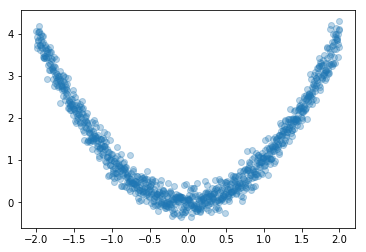

In [2]:
# Generate some data
x = np.linspace(-2, 2, 1000).reshape(-1, 1)
y = x**2 + np.random.randn(*x.shape) * 0.2

# Visualise it in a scatter plot
plt.scatter(x, y, alpha=0.3)

Let's pull a few pieces from Keras.

In [3]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


Next, let's put together a tiny neural net, with only one hidden layer.

In [61]:
np.random.seed(3)

In [62]:
model = Sequential()
model.add(Dense(2, activation="relu", input_dim=1))
model.add(Dense(1, activation="linear"))

We're done defining the net itself. We now need to provide some information for the loss function and gradient descent options.

In [63]:
model.compile(optimizer="sgd", loss="mse")

We're ready to train the net.

In [64]:
history = model.fit(x, y, epochs=30, batch_size=16, verbose=0)

How did we do ?

In [65]:
def plot_network_results(x=x, y=y, model=model, history=history):
    
    plt.figure(figsize=(15, 4))
    
    plt.subplot(121)
    plt.scatter(x, y, alpha=0.3)
    plt.plot(x, model.predict(x), lw=5, c="k")
    plt.legend(["Prediction", "Data"])
    
    plt.subplot(122)
    plt.plot(history.history["loss"], lw=5)
    plt.title("Loss")
    plt.xlabel("Epochs")

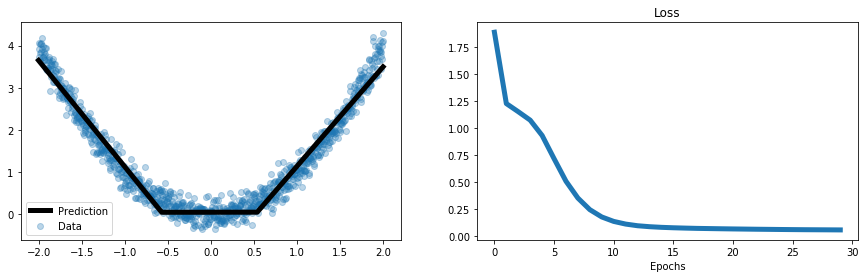

In [66]:
plot_network_results()

A tiny neural network, with one hidden layer containing two units, was able to learn a good approximation of our function.

We say "tiny", but how small is it, really ?

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


### Predicting commute times

Without further ado, let's train a larger network on some more realistic data.

In [68]:
import pandas as pd

# Let's import our data
training_data = pd.read_csv("../data/commute-times-train.csv", index_col=[0])
test_data = pd.read_csv("../data/commute-times-test.csv", index_col=[0])

In [69]:
### ASSUME WE HAVE READ PROCESSED DATA
def l1_norm(data):
    
    data.loc[:, "l1_norm"] = (
        data["destination_latitude"] + data["destination_longitude"] -
        data["source_latitude"] - data["source_longitude"]
    )
    
    return data


def l2_norm(data):
    
    data.loc[:, "l2_norm"] = (
        (data["destination_latitude"] - data["source_latitude"]) ** 2 +
        (data["destination_longitude"] - data["source_longitude"]) ** 2
    ) ** 0.5
    
    return data


def dummies(data):
    
    data = pd.concat([data, pd.get_dummies(data["commute_type"])], axis=1).drop(["commute_type"], axis=1)
    return data


def time_of_day(data):
    
    data["time_of_day_ts"] = pd.to_datetime(data["time_of_day_ts"])
    data["time_of_day"] = data["time_of_day_ts"].dt.hour + data["time_of_day_ts"].dt.minute / 60
    return data.drop(["time_of_day_ts"], axis=1)


training_data = l1_norm(l2_norm(dummies(time_of_day(training_data))))
test_data = l1_norm(l2_norm(dummies(time_of_day(test_data))))

In [70]:
X_train, y_train = training_data.drop(["commute_time"], axis=1), training_data["commute_time"]
X_test, y_test = test_data.drop(["commute_time"], axis=1), test_data["commute_time"]

### Neural networks appreciate scaled data

Because most of the "interesting action" in an activation function occurs near zero, the neural net often learns best when it is fed data that is around zero mean, and scaled to reasonable variance.

[We learn our scaling parameters](https://sebastianraschka.com/faq/docs/scale-training-test.html) from the training data, and apply them to the test data, to ensure our scaling is the same on both datasets.

In [71]:
from sklearn.preprocessing import StandardScaler

# Define a standard scaler
scaler = StandardScaler()

# Fit the scaler to the training data, and transform that
X_train = scaler.fit_transform(X_train)

# Transform the test data using the same parameters
X_test = scaler.transform(X_test)

### Now let's build a neural net

In [72]:
from keras.layers import Activation
import numpy as np

In [73]:
# A single hidden layer net, trained with stochastic gradient descent

model = Sequential()
model.add(Dense(32, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="sgd")

history = model.fit(X_train, y_train, epochs=30, verbose=0, validation_data=(X_test, y_test))

### We're going to need some way to see how well we did

In [94]:
def evaluate_net(model, history, X_test=X_test, y_test=y_test):
    
    plt.semilogy(history.history["loss"], lw=3)
    plt.semilogy(history.history["val_loss"], lw=3, alpha=0.7)
    plt.title("Final RMSE : {:.2f}".format(np.sqrt(model.evaluate(X_test, y_test, verbose=0))))
    plt.xlabel("Epochs")
    plt.ylabel("MSE loss")
    plt.legend(["Train", "Test"])

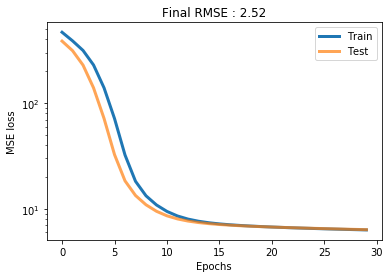

In [75]:
evaluate_net(model, history)

### We need to go deeper

Well, at least most of us *want* to. However, before we add more layers, there are a few things we need to think about :

- learning rate
- minibatch size
- number of epochs

### Learning rate

If your learning rate is too high, you can overshoot in gradient descent, never finding the minimum, or worse, diverging completely. If your learning rate is too low, you will take a very long time training.

In [133]:
from keras.optimizers import SGD
from keras.callbacks import TerminateOnNaN


def train_net(lr=0.01, batch_size=32, epochs=20, verbose=0, large=False):
    
    model = Sequential()
    model.add(Dense(32, activation="relu", input_dim=X_train.shape[1]))
    if large:
        model.add(Dense(256, activation="relu"))
        model.add(Dense(256, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss="mse", optimizer=SGD(lr))
    history = model.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=int(batch_size), 
        validation_data=(X_test, y_test),
        callbacks=[TerminateOnNaN()],
        verbose=verbose
    )
    
    if "val_loss" not in history.history:
        history.history["val_loss"] = [np.nan]
    return model, history


def compare_nets(first_model, first_history, second_model, second_history):
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    evaluate_net(first_model, first_history)
    
    plt.subplot(122)
    evaluate_net(second_model, second_history)
    
    plt.tight_layout()

Batch 6: Invalid loss, terminating training


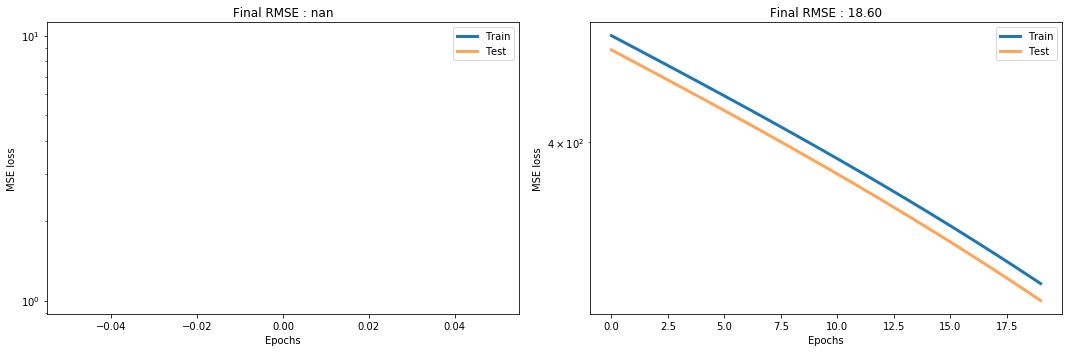

In [125]:
lr_high_model, lr_high_history = train_net(lr=0.1)
lr_low_model, lr_low_history = train_net(lr=1e-6)

compare_nets(lr_high_model, lr_high_history, lr_low_model, lr_low_history)

### Minibatches

A minibatch is like training on a small part of your data at a time : you forwards-propagate your minibatch, backpropagate your errors, and adjust your weights using gradient descent. Then you do the same on another minibatch. The advantage is that you update your weights a lot more often than in a single minibatch.

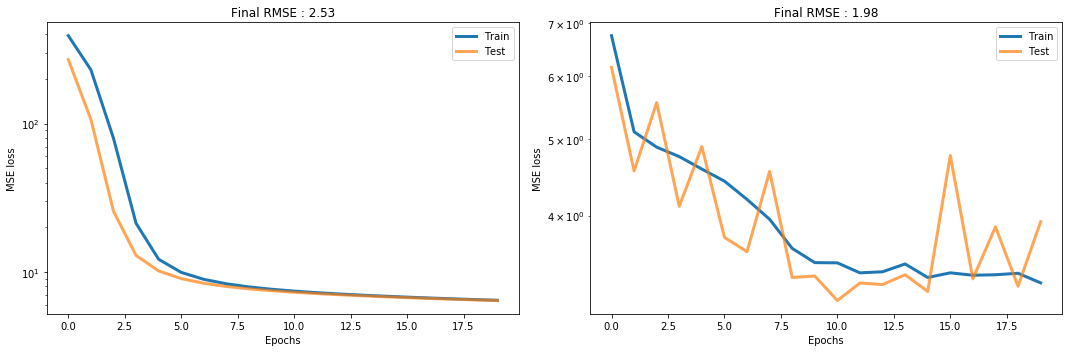

In [126]:
mb_large_model, mb_large_history = train_net(batch_size=len(X_train)/2)
mb_small_model, mb_small_history = train_net(batch_size=8)

compare_nets(mb_large_model, mb_large_history, mb_small_model, mb_small_history)

### Number of epochs

At the beginning, the more you train, the better your model gets. At some point, however, your model begins to overfit -- it stops learning the general function that maps your inputs to your outputs, and it begins learning the small intricacies of your training set. At this point, your training loss is still decreasing, but the test loss begins increasing.

Train on 20000 samples, validate on 10000 samples
Epoch 1/200
3s - loss: 12.6830 - val_loss: 10.1679
Epoch 2/200
1s - loss: 5.9543 - val_loss: 5.0807
Epoch 3/200
1s - loss: 5.0340 - val_loss: 4.5899
Epoch 4/200
1s - loss: 4.8932 - val_loss: 3.9598
Epoch 5/200
1s - loss: 4.6883 - val_loss: 4.3097
Epoch 6/200
1s - loss: 4.6529 - val_loss: 4.5065
Epoch 7/200
1s - loss: 4.5777 - val_loss: 3.8410
Epoch 8/200
2s - loss: 4.3280 - val_loss: 6.7073
Epoch 9/200
2s - loss: 4.5729 - val_loss: 3.6468
Epoch 10/200
2s - loss: 4.3968 - val_loss: 4.4762
Epoch 11/200
2s - loss: 4.3578 - val_loss: 3.6183
Epoch 12/200
1s - loss: 4.5016 - val_loss: 4.7473
Epoch 13/200
1s - loss: 4.3718 - val_loss: 3.5545
Epoch 14/200
2s - loss: 4.4107 - val_loss: 3.7197
Epoch 15/200
2s - loss: 4.3276 - val_loss: 5.2806
Epoch 16/200
2s - loss: 4.3789 - val_loss: 3.9143
Epoch 17/200
2s - loss: 4.2075 - val_loss: 4.6863
Epoch 18/200
1s - loss: 4.2667 - val_loss: 3.6604
Epoch 19/200
1s - loss: 4.1387 - val_loss: 3.7693
Epoch 2

1s - loss: 1.6954 - val_loss: 1.6619
Epoch 164/200
1s - loss: 1.6476 - val_loss: 1.7909
Epoch 165/200
2s - loss: 1.6204 - val_loss: 1.7970
Epoch 166/200
2s - loss: 1.5873 - val_loss: 1.9804
Epoch 167/200
2s - loss: 1.5676 - val_loss: 1.7572
Epoch 168/200
2s - loss: 1.5243 - val_loss: 1.6990
Epoch 169/200
2s - loss: 1.4950 - val_loss: 1.6570
Epoch 170/200
2s - loss: 1.4959 - val_loss: 1.5481
Epoch 171/200
2s - loss: 1.4667 - val_loss: 1.5566
Epoch 172/200
2s - loss: 1.4588 - val_loss: 1.4823
Epoch 173/200
2s - loss: 1.4466 - val_loss: 1.5673
Epoch 174/200
2s - loss: 1.4366 - val_loss: 1.4979
Epoch 175/200
2s - loss: 1.3926 - val_loss: 1.9458
Epoch 176/200
2s - loss: 1.3938 - val_loss: 1.4570
Epoch 177/200
2s - loss: 1.4157 - val_loss: 1.4319
Epoch 178/200
2s - loss: 1.3622 - val_loss: 1.5254
Epoch 179/200
2s - loss: 1.3468 - val_loss: 1.4665
Epoch 180/200
2s - loss: 1.3390 - val_loss: 1.4895
Epoch 181/200
2s - loss: 1.3020 - val_loss: 1.6660
Epoch 182/200
2s - loss: 1.3683 - val_loss: 1

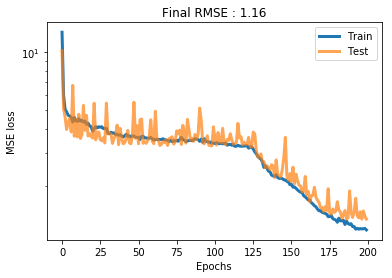

In [136]:
long_train_model, long_train_history = train_net(epochs=500, lr=0.005, large=True, verbose=2)
evaluate_net(long_train_model, long_train_history)

In [78]:
# Two, bigger layers now, and trained for longer

model = Sequential()
model.add(Dense(64, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="sgd")

history = model.fit(X_train, y_train, epochs=250, verbose=2, validation_data=(X_test, y_test))
evaluate_net(model, history)

Train on 20000 samples, validate on 10000 samples
Epoch 1/250
1s - loss: 24.2384 - val_loss: 4.1522
Epoch 2/250
1s - loss: nan - val_loss: nan
Epoch 3/250
0s - loss: nan - val_loss: nan
Epoch 4/250
0s - loss: nan - val_loss: nan
Epoch 5/250
0s - loss: nan - val_loss: nan
Epoch 6/250
0s - loss: nan - val_loss: nan
Epoch 7/250
0s - loss: nan - val_loss: nan
Epoch 8/250
0s - loss: nan - val_loss: nan
Epoch 9/250
0s - loss: nan - val_loss: nan
Epoch 10/250
0s - loss: nan - val_loss: nan
Epoch 11/250
0s - loss: nan - val_loss: nan
Epoch 12/250
0s - loss: nan - val_loss: nan
Epoch 13/250
0s - loss: nan - val_loss: nan
Epoch 14/250
0s - loss: nan - val_loss: nan
Epoch 15/250
0s - loss: nan - val_loss: nan
Epoch 16/250
0s - loss: nan - val_loss: nan
Epoch 17/250
0s - loss: nan - val_loss: nan
Epoch 18/250
0s - loss: nan - val_loss: nan
Epoch 19/250
0s - loss: nan - val_loss: nan
Epoch 20/250
0s - loss: nan - val_loss: nan
Epoch 21/250
0s - loss: nan - val_loss: nan
Epoch 22/250
0s - loss: nan 

KeyboardInterrupt: 

In [ ]:
history.history

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation

%matplotlib inline

### Raw data

In [14]:
# Read in the raw data
data = pd.read_csv("../data/commute-times-train.csv", index_col=[0])

data.head()

,source_latitude,source_longitude,destination_latitude,destination_longitude,time_of_day_ts,commute_type,commute_time
0,-0.182809,0.361579,0.485623,0.300347,2018-08-13 16:56:00,BUS,25.156297
1,0.160297,0.064330,0.702545,-0.116307,2018-08-13 18:19:00,CAR,12.937429
2,0.762229,0.486693,0.197252,0.790051,2018-08-13 17:36:00,BIKE,29.013729
3,0.187947,0.508487,-0.372924,-0.914006,2018-08-13 07:41:00,CAR,18.215423
4,-0.431013,-0.600620,0.729273,0.215633,2018-08-13 15:56:00,TRAIN,11.196802


### Generate some basic features

This is just to mess around with what I expect Susan might create.

In [15]:
# Create some categorical variables from commute_type
data = pd.concat([data, pd.get_dummies(data["commute_type"])], axis=1).drop(["commute_type"], axis=1)

# Add L2 norm -- it "makes sense" and you might well create this if you 
# didn't know how the data was generated;
# the L1 norm would just be a collinearity mess
data.loc[:, "distance"] = np.sqrt(
    (data["destination_latitude"] - data["source_latitude"])**2 +
    (data["destination_longitude"] - data["source_longitude"])**2
)

data["time_of_day_ts"] = pd.to_datetime(data["time_of_day_ts"])
data["time_of_day"] = data["time_of_day_ts"].dt.hour + data["time_of_day_ts"].dt.minute / 60

data = data.drop(["time_of_day_ts"], axis=1)

data.head()

,source_latitude,source_longitude,destination_latitude,destination_longitude,commute_time,BIKE,BUS,CAR,TRAIN,WALK,distance,time_of_day
0,-0.182809,0.361579,0.485623,0.300347,25.156297,0,1,0,0,0,0.671231,16.933333
1,0.160297,0.064330,0.702545,-0.116307,12.937429,0,0,1,0,0,0.571544,18.316667
2,0.762229,0.486693,0.197252,0.790051,29.013729,1,0,0,0,0,0.641268,17.600000
3,0.187947,0.508487,-0.372924,-0.914006,18.215423,0,0,1,0,0,1.529073,7.683333
4,-0.431013,-0.600620,0.729273,0.215633,11.196802,0,0,0,1,0,1.418637,15.933333


### Create train and test datasets and scale the features for neural net use

In [16]:
np.random.seed(0)

# Create X and y
X = data.drop(["commute_time"], axis=1)
y = data["commute_time"]

# Scale features
X = StandardScaler().fit_transform(X)

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Linear regression

In [17]:
# Train a linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Calculate its RMSE
lr_rmse = np.sqrt(np.mean( (lr.predict(X_test) - y_test)**2 ) )
print("RMSE linear regression : {:.2f}".format(lr_rmse))
print("( R^2 : {:.3f} )".format(lr.score(X_test, y_test)))

RMSE linear regression : 2.24
( R^2 : 0.926 )


### Neural net

RMSE neural network : 1.35


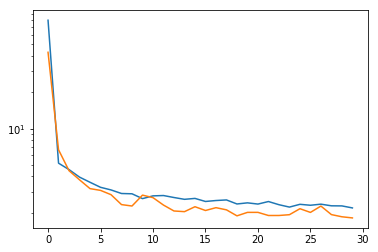

In [19]:
# Simple neural net : three hidden layers, Adam optimiser

model = Sequential()

model.add(Dense(512,  input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation("linear"))

model.compile(loss="mse", optimizer="adam")

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=30,
    verbose=0,
    validation_data=(X_test, y_test)
)

# Calculate RMSE
nn_rmse = np.sqrt(model.evaluate(X_test, y_test, verbose=0))
print("RMSE neural network : {:.2f}".format(nn_rmse))

plt.semilogy(history.history["loss"])
plt.semilogy(history.history["val_loss"])

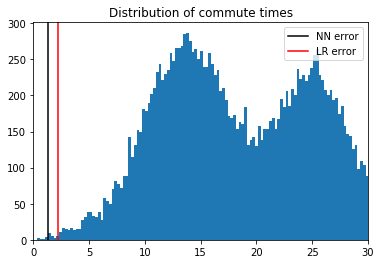

In [20]:
plt.hist(data["commute_time"], bins=200)
plt.axvline(nn_rmse, c="k")
plt.axvline(lr_rmse, c="r")
plt.xlim(0, 30)
plt.title("Distribution of commute times")
plt.legend(["NN error", "LR error"])

### TL; DR :

RMSE of 4.76 for neural nets and 5.59 for linear regression. Compared with the distribution of commute times, it's "realistic", sure, but not great or encouraging. I'm going to keep tweaking the net, and we might have more features, but I think we can make this a little easier -- not much, just a touch.

### Ignore -- grid-searching NNs for posterity

In [30]:
layers = [1, 2, 3, 4, 5, 6, 7]
layer_sizes = [64, 128, 256, 512]
reg_type = ["bn", "do", None]

np.random.seed(0)

def score_nn(layers, layer_size, reg):
    
    np.random.seed(0)
    
    model = Sequential()
    
    model.add(Dense(layer_size, activation="relu", input_dim=X_train.shape[1]))
    if reg is not None:
        if reg == "bn":
            model.add(BatchNormalization())
        elif reg == "do": 
            model.add(Dropout(0.2))
    
    for _ in range(layers-1):
        model.add(Dense(layer_size, activation="relu"))
        if reg is not None:
            if reg == "bn":
                model.add(BatchNormalization())
            elif reg == "do": 
                model.add(Dropout(0.2))
                
    model.add(Dense(1, activation="linear"))
    
    np.random.seed(0)
    model.compile(loss="mse", optimizer="adam")
    np.random.seed(0)

    history = model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=30,
        verbose=0,
        validation_data=(X_test, y_test)
    )

    # Calculate RMSE
    nn_rmse = np.sqrt(model.evaluate(X_test, y_test, verbose=0))

    return nn_rmse

In [ ]:
from tqdm import tqdm

results_bn = np.zeros((len(layers), len(layer_sizes)))
results_do = np.zeros((len(layers), len(layer_sizes)))
results_none = np.zeros((len(layers), len(layer_sizes)))

for i, layer in enumerate(tqdm(layers, desc="BN")):
    for j, layer_size in enumerate(layer_sizes):
        results_bn[i, j] = score_nn(layer, layer_size, "bn")
        
for i, layer in enumerate(tqdm(layers, desc="DO")):
    for j, layer_size in enumerate(layer_sizes):
        results_bn[i, j] = score_nn(layer, layer_size, "do")
        
for i, layer in enumerate(tqdm(layers, desc="None")):
    for j, layer_size in enumerate(layer_sizes):
        results_bn[i, j] = score_nn(layer, layer_size, None)

DO:  43%|████▎     | 3/7 [05:18<07:02, 105.68s/it]

In [33]:
results_bn

5.091942824612819